In [2]:
import pandas as pd
import numpy as np
from plotnine import *
import glob
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

In [20]:
categories = [
    {"name": "FTA", "path": "weekly_failures/fta_websites.parquet"},
    {"name": "Web User", "path": "weekly_failures/outage_report.parquet"},
    {"name": "Cloud User", "path": "weekly_failures/cloud_user_reports.parquet"},
    {"name": "Cloud Operator", "path": "weekly_failures/cloud_provider_reports.parquet"},
    {"name": "Web Operator", "path": "weekly_failures/websites_operator_reported.parquet"},
    {"name": "Online Games", "path": "weekly_failures/online_games.parquet"},
]

In [72]:
all_how_dfs = []
for item in categories:
    dataset_name = item["name"]
    partial_how_df = pd.read_parquet(item["path"])
    if dataset_name == "Web User":
        mask = (partial_how_df["vendor"] == "Instagram") | (partial_how_df["vendor"] == "Netflix") | (partial_how_df["vendor"] == "Gmail")
        partial_how_df = partial_how_df[mask].reset_index(drop=True)
    elif dataset_name == "FTA":
        # www.microsoft.com, www.bbc.co.uk, www.fifa.com
        mask = ((partial_how_df["vendor"] == "www.microsoft.com") 
        | (partial_how_df["vendor"] == "www.bbc.co.uk") 
        | (partial_how_df["vendor"] == "www.fifa.com"))
        partial_how_df = partial_how_df[mask].reset_index(drop=True)
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("www.microsoft.com", "Msft")
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("www.bbc.co.uk", "BBC")
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("www.fifa.com", "FIFA")
    elif dataset_name == "Web Operator":
        mask = ((partial_how_df["vendor"] == "atlassian_jira-software") 
        | (partial_how_df["vendor"] == "slack_global-status") 
        | (partial_how_df["vendor"] == "github-status_global-status"))
        partial_how_df = partial_how_df[mask].reset_index(drop=True)
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("atlassian_jira-software", "Jira")
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("slack_global-status", "Slack")
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("github-status_global-status", "Github")
    elif dataset_name == "Cloud User":
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("azure", "Azure")
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("aws", "AWS")
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("gcp", "GCP")
    elif dataset_name == "Online Games":
        mask = ((partial_how_df["vendor"] == "runescape") 
        | (partial_how_df["vendor"] == "hypixel") 
        | (partial_how_df["vendor"] == "minehut"))
        partial_how_df = partial_how_df[mask].reset_index(drop=True)
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("runescape", "Runescape")
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("hypixel", "Hypixel")
        partial_how_df["vendor"] = partial_how_df["vendor"].str.replace("minehut", "Minehut")
    partial_how_df["name"] = item["name"]
    all_how_dfs.append(partial_how_df)
how_df = pd.concat(all_how_dfs).reset_index(drop=True)
how_df["name"] = pd.Categorical(how_df["name"], 
                ["FTA", "Web User", "Web Operator", "Online Games", "Cloud User", "Cloud Operator"])
how_df

,vendor,hourofweek,num_failures,name
0,BBC,0,22,FTA
1,BBC,1,20,FTA
2,BBC,2,20,FTA
3,BBC,3,20,FTA
4,BBC,4,18,FTA
...,...,...,...,...
2116,Runescape,163,11,Online Games
2117,Runescape,164,13,Online Games
2118,Runescape,165,13,Online Games
2119,Runescape,166,6,Online Games


In [73]:
vendors = how_df["vendor"].unique()
normalized_dfs = []
for vendor in vendors:
    partial_df = how_df.loc[how_df["vendor"] == vendor, :].reset_index(drop=True)
    partial_df["norm_failures"] = partial_df["num_failures"] / partial_df["num_failures"].sum()
    normalized_dfs.append(partial_df)
normalized_df = pd.concat(normalized_dfs).reset_index(drop=True)
normalized_df

,vendor,hourofweek,num_failures,name,norm_failures
0,BBC,0,22,FTA,0.007711
1,BBC,1,20,FTA,0.007010
2,BBC,2,20,FTA,0.007010
3,BBC,3,20,FTA,0.007010
4,BBC,4,18,FTA,0.006309
...,...,...,...,...,...
2116,Runescape,163,11,Online Games,0.004699
2117,Runescape,164,13,Online Games,0.005553
2118,Runescape,165,13,Online Games,0.005553
2119,Runescape,166,6,Online Games,0.002563


In [74]:
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt

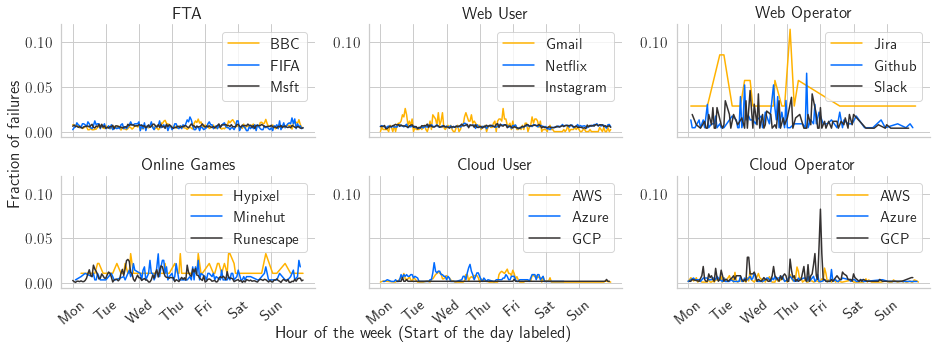

In [146]:
sns.set_theme(style="whitegrid", font_scale=1.4)
g = sns.FacetGrid(normalized_df, col="name",  hue="vendor",
                  col_wrap=3,
                 palette=sns.color_palette(["#FFB200","#006BFF","#343131"]),
                 height=2.5, aspect=16/9)
g.map(plt.plot, "hourofweek", "norm_failures")
g.set_titles("{col_name}")
g.set_axis_labels(x_var="", y_var="")
for ax in g.axes:
    ax.set_xticks([0, 24, 48, 72, 96, 120, 144], 
                     labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
                     rotation=40)
g.fig.text(x=0.3, y=0.03, s="Hour of the week (Start of the day labeled)")
g.fig.text(x=0.02, y=0.4, s="Fraction of failures", rotation=90)


for ax in g.axes.ravel():
    ax.legend()

g.fig.savefig("plots_png/weekly_trend.png", dpi=500)
g.fig.savefig("plots_pdf/weekly_trend.pdf")